In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

sns.set_style("darkgrid")
pd.set_option("display.max_columns", None)

In [5]:
import os
import pandas as pd

FILENAME = "clean_laps.csv"

def find_file(filename, search_root="."):
    for root, _, files in os.walk(search_root):
        if filename in files:
            return os.path.join(root, filename)
    raise FileNotFoundError(f"{filename} not found anywhere in the project.")

# Find and load the CSV automatically
file_path = find_file(FILENAME)
print(f"Loaded data from: {file_path}")

laps = pd.read_csv(file_path)

# Convert lap time to seconds
laps["LapTimeSeconds"] = pd.to_timedelta(laps["LapTime"]).dt.total_seconds()

laps.head()

Loaded data from: ./clean_laps.csv


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
0,0 days 01:05:19.554000,VER,1,0 days 00:01:33.433000,2.0,1.0,NaN,NaN,0 days 00:00:29.616000,0 days 00:00:38,0 days 00:00:25.817000,0 days 01:04:15.751000,0 days 01:04:53.751000,0 days 01:05:19.568000,290.0,255.0,244.0,291.0,True,MEDIUM,2.0,True,Red Bull Racing,0 days 01:03:46.121000,2023-07-09 14:04:47.157,1,2.0,False,NaN,False,True,93.433
1,0 days 01:06:52.284000,VER,1,0 days 00:01:32.730000,3.0,1.0,NaN,NaN,0 days 00:00:29.380000,0 days 00:00:37.690000,0 days 00:00:25.660000,0 days 01:05:48.948000,0 days 01:06:26.638000,0 days 01:06:52.298000,311.0,259.0,245.0,318.0,True,MEDIUM,3.0,True,Red Bull Racing,0 days 01:05:19.554000,2023-07-09 14:06:20.590,1,2.0,False,NaN,False,True,92.730
2,0 days 01:08:25.064000,VER,1,0 days 00:01:32.780000,4.0,1.0,NaN,NaN,0 days 00:00:29.407000,0 days 00:00:37.650000,0 days 00:00:25.723000,0 days 01:07:21.705000,0 days 01:07:59.355000,0 days 01:08:25.078000,313.0,259.0,245.0,316.0,False,MEDIUM,4.0,True,Red Bull Racing,0 days 01:06:52.284000,2023-07-09 14:07:53.320,1,2.0,False,NaN,False,True,92.780
3,0 days 01:09:57.646000,VER,1,0 days 00:01:32.582000,5.0,1.0,NaN,NaN,0 days 00:00:29.338000,0 days 00:00:37.403000,0 days 00:00:25.841000,0 days 01:08:54.416000,0 days 01:09:31.819000,0 days 01:09:57.660000,320.0,254.0,244.0,288.0,True,MEDIUM,5.0,True,Red Bull Racing,0 days 01:08:25.064000,2023-07-09 14:09:26.100,1,1.0,False,NaN,False,True,92.582
4,0 days 01:11:30.673000,VER,1,0 days 00:01:33.027000,6.0,1.0,NaN,NaN,0 days 00:00:29.667000,0 days 00:00:37.543000,0 days 00:00:25.817000,0 days 01:10:27.327000,0 days 01:11:04.870000,0 days 01:11:30.687000,290.0,255.0,245.0,285.0,False,MEDIUM,6.0,True,Red Bull Racing,0 days 01:09:57.646000,2023-07-09 14:10:58.682,1,1.0,False,NaN,False,True,93.027


In [6]:
laps.isnull().sum()

laps["Compound"].value_counts()

Compound
MEDIUM    438
SOFT      248
HARD      116
Name: count, dtype: int64

In [7]:
valid_compounds = ["SOFT", "MEDIUM", "HARD"]

laps = laps[laps["Compound"].isin(valid_compounds)]
laps = laps[laps["IsAccurate"] == True]

laps.shape

(802, 32)

In [8]:
laps["TireAge"] = (
    laps.groupby(["Driver", "Stint"])
    .cumcount() + 1
)

laps[["Driver", "Stint", "LapNumber", "TireAge"]].head()

,Driver,Stint,LapNumber,TireAge
0,VER,1.0,2.0,1
1,VER,1.0,3.0,2
2,VER,1.0,4.0,3
3,VER,1.0,5.0,4
4,VER,1.0,6.0,5


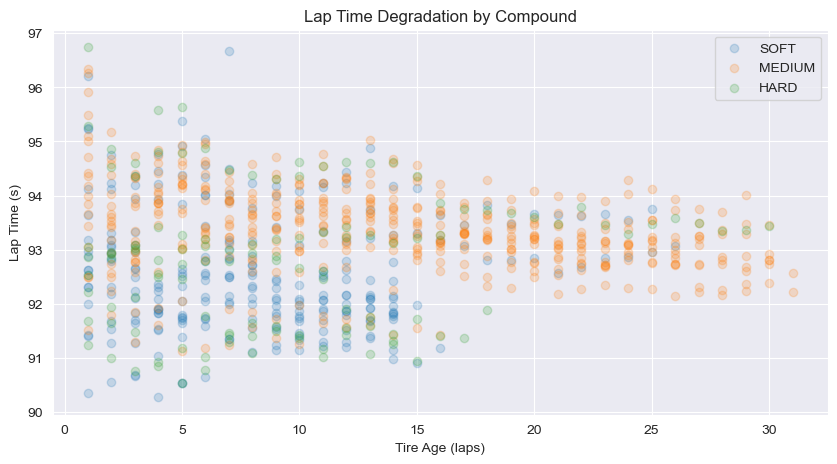

In [9]:
plt.figure(figsize=(10, 5))

for compound in valid_compounds:
    subset = laps[laps["Compound"] == compound]
    plt.scatter(
        subset["TireAge"],
        subset["LapTimeSeconds"],
        alpha=0.2,
        label=compound
    )

plt.xlabel("Tire Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title("Lap Time Degradation by Compound")
plt.legend()
plt.show()

In [10]:
features = [
    "TireAge",
    "LapNumber"
]

target = "LapTimeSeconds"

X = laps[features + ["Compound"]]
y = laps[target]

In [11]:
compound_encoder = LabelEncoder()
X["CompoundEncoded"] = compound_encoder.fit_transform(X["Compound"])
X.drop(columns=["Compound"], inplace=True)

X.head()

/var/folders/bc/cyhrnn555rl1vghbr4s9rw_m0000gn/T/ipykernel_66676/163047443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["CompoundEncoded"] = compound_encoder.fit_transform(X["Compound"])
/var/folders/bc/cyhrnn555rl1vghbr4s9rw_m0000gn/T/ipykernel_66676/163047443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=["Compound"], inplace=True)


,TireAge,LapNumber,CompoundEncoded
0,1,2.0,1
1,2,3.0,1
2,3,4.0,1
3,4,5.0,1
4,5,6.0,1


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [13]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [14]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} seconds")

Mean Absolute Error: 0.43 seconds


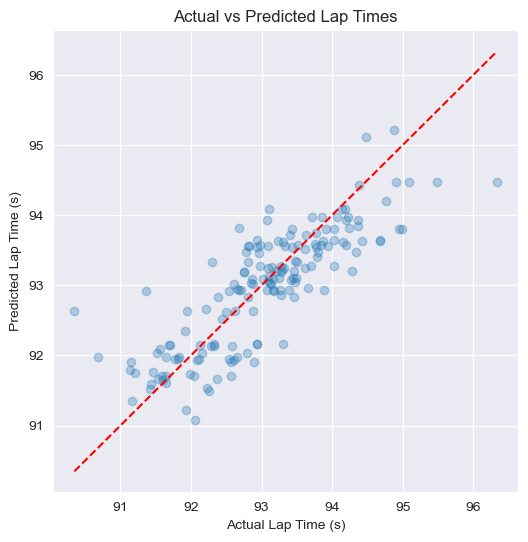

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "--r"
)
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Actual vs Predicted Lap Times")
plt.show()

In [16]:
def simulate_stint(compound, start_lap=1, stint_length=25):
    compound_encoded = compound_encoder.transform([compound])[0]
    
    data = pd.DataFrame({
        "TireAge": np.arange(1, stint_length + 1),
        "LapNumber": np.arange(start_lap, start_lap + stint_length),
        "CompoundEncoded": compound_encoded
    })
    
    return model.predict(data)

    

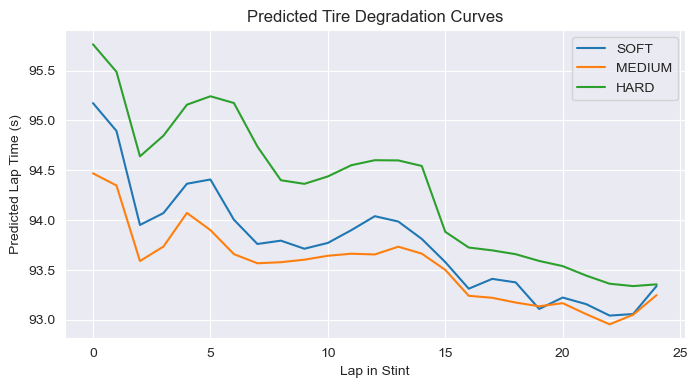

In [17]:
plt.figure(figsize=(8, 4))

for compound in valid_compounds:
    lap_times = simulate_stint(compound)
    plt.plot(lap_times, label=compound)

plt.xlabel("Lap in Stint")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Predicted Tire Degradation Curves")
plt.legend()
plt.show()

In [18]:
importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance

LapNumber          0.851178
TireAge            0.081872
CompoundEncoded    0.066950
dtype: float64

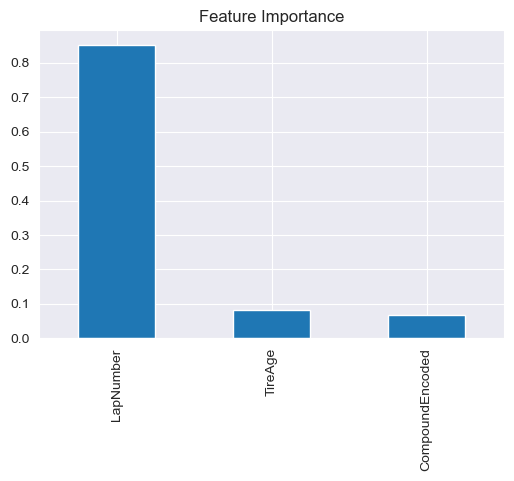

In [19]:
importance.plot(kind="bar", figsize=(6,4), title="Feature Importance")
plt.show()

In [21]:
import os
import joblib

# Directory where models will be stored
MODEL_DIR = "../models"

# Create directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model and encoder
model_path = os.path.join(MODEL_DIR, "tire_degradation_model.pkl")
encoder_path = os.path.join(MODEL_DIR, "compound_encoder.pkl")

joblib.dump(model, model_path)
joblib.dump(compound_encoder, encoder_path)

print(f"Model saved to: {model_path}")
print(f"Encoder saved to: {encoder_path}")

Model saved to: ../models/tire_degradation_model.pkl
Encoder saved to: ../models/compound_encoder.pkl
